In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score,
    make_scorer,
    roc_curve,
    confusion_matrix,
    precision_recall_curve,
    auc,
)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold

In [2]:
ap_pro_data = pd.read_csv("./resources/datasets/ap_pro/continuous.csv")
ap_pro_data

,VisitID,RecordID,Age,Sex,PainDur,PainSite,PainType,Vomiting,PrevVis,Temp,TendSite,Guard,RebTend,PainShift,WBC,Triage,Observer
0,1,1,"13,08",female,"144,00",lower_abdomen,constant,yes,no,"37,40",lower_abdomen,no,no,no,?,discharge,discharge
1,2,2,"4,77",female,"120,00",lower_abdomen,intermittent,no,no,"35,70",other,no,no,no,?,discharge,discharge
2,3,3,"11,23",male,"11,00",lower_abdomen,constant,no,no,"35,90",lower_abdomen,no,yes,no,"18,60",consult,observation
3,4,4,"11,01",female,"24,00",other,constant,no,yes,"37,80",other,no,no,no,"17,00",discharge,discharge
4,5,5,"2,41",female,"3,00",other,intermittent,yes,no,"38,20",other,no,no,no,?,discharge,observation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,453,453,"10,48",male,"12,00",RLQ,intermittent,no,no,"36,70",RLQ,no,no,no,?,discharge,discharge
453,454,454,"9,84",male,"12,00",other,intermittent,yes,no,"36,80",other,no,no,no,?,discharge,discharge
454,455,455,"3,53",female,"24,00",other,intermittent,no,no,?,other,no,no,no,?,discharge,observation
455,456,456,"4,16",female,"48,00",lower_abdomen,intermittent,yes,no,"37,60",?,no,no,no,?,discharge,discharge


In [3]:
def show_missing_values(df: pd.DataFrame) -> None:
    df.replace("?", np.nan, inplace=True)
    missing_values = df.isna().sum()
    return missing_values[missing_values > 0].sort_values(ascending=False)


show_missing_values(ap_pro_data)

WBC          354
TendSite      55
PainShift      9
Temp           7
PrevVis        5
RebTend        5
PainType       4
Vomiting       4
Guard          3
PainDur        1
dtype: int64

In [4]:
continuous_attributes = ["Age", "PainDur", "Temp"]  # "WBC"
binary_attributes = ["Vomiting", "PrevVis", "Guard", "RebTend", "PainShift"]
categorical_attributes = ["Sex", "PainSite", "PainType", "TendSite"] + binary_attributes

In [5]:
def prepare_data(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    df.drop(columns=["VisitID", "RecordID", "Observer"], inplace=True)
    df.replace("?", np.nan, inplace=True)
    df.dropna(axis=1, thresh=len(ap_pro_data) // 2, inplace=True)

    df["Triage"] = df["Triage"].apply(lambda x: True if x == "consult" else False)

    df = pd.get_dummies(df, columns=categorical_attributes)

    for attribute in continuous_attributes:
        df[attribute] = df[attribute].apply(lambda x: float(str(x).replace(",", ".")))

    # for attribute in binary_attributes:
    #     df[attribute] = df[attribute].apply(lambda x: 1 if x == "yes" or x == "constant" else 0)

    return df.drop(columns=["Triage"]), df["Triage"]


X, y = prepare_data(ap_pro_data)
X.head()

,Age,PainDur,Temp,Sex_female,Sex_male,PainSite_RLQ,PainSite_lower_abdomen,PainSite_other,PainType_constant,PainType_intermittent,...,Vomiting_no,Vomiting_yes,PrevVis_no,PrevVis_yes,Guard_no,Guard_yes,RebTend_no,RebTend_yes,PainShift_no,PainShift_yes
0,13.08,144.0,37.4,True,False,False,True,False,True,False,...,False,True,True,False,True,False,True,False,True,False
1,4.77,120.0,35.7,True,False,False,True,False,False,True,...,True,False,True,False,True,False,True,False,True,False
2,11.23,11.0,35.9,False,True,False,True,False,True,False,...,True,False,True,False,True,False,False,True,True,False
3,11.01,24.0,37.8,True,False,False,False,True,True,False,...,True,False,False,True,True,False,True,False,True,False
4,2.41,3.0,38.2,True,False,False,False,True,False,True,...,False,True,True,False,True,False,True,False,True,False


In [6]:
y.value_counts()

Triage
False    409
True      48
Name: count, dtype: int64

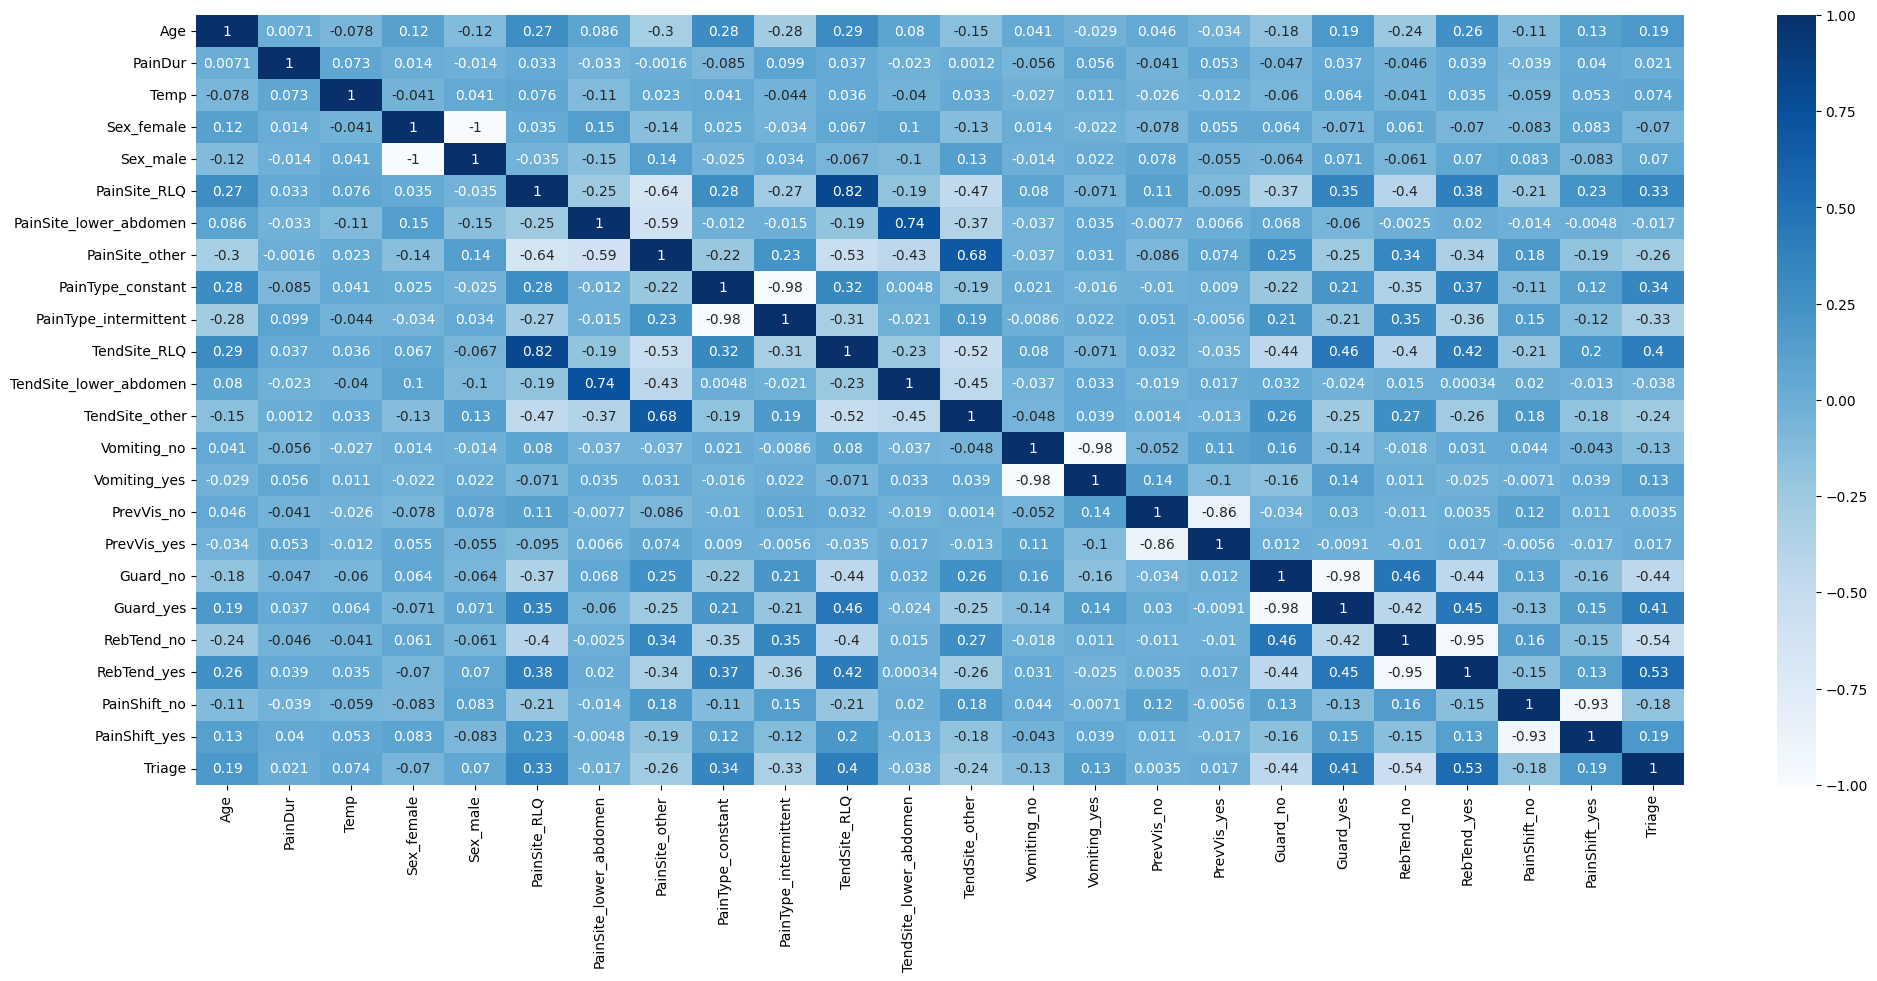

In [7]:
def show_correlations(df: pd.DataFrame) -> None:
    plt.figure(figsize=(24, 10))
    correlation_matrix = df.corr(method="kendall")
    sns.heatmap(correlation_matrix, annot=True, cmap="Blues")


show_correlations(pd.concat([X, y], axis=1))

In [8]:
def get_baseline_classifier() -> Pipeline:
    return Pipeline([("imputer", SimpleImputer()), ("clf", LogisticRegression(max_iter=10000))])


def auprc_score(y: np.ndarray, y_pred: np.ndarray) -> float:
    precision, recall, _ = precision_recall_curve(y, y_pred)
    return auc(recall, precision)


def get_target_classifier(X: np.ndarray, y: np.ndarray) -> Pipeline:
    pipeline = Pipeline(
        [
            ("imputer", KNNImputer()),
            ("smote", SMOTE(random_state=42)),
            (
                "rf",
                RandomForestClassifier(
                    class_weight="balanced",
                    random_state=42,
                    min_samples_leaf=8,
                    min_samples_split=2,
                    n_estimators=75,
                ),
            ),
        ]
    )
    param_grid = {
        # "rf__n_estimators": [50, 75, 100, 150, 200],
        # "rf__max_depth": [None, 5, 10, 15, 20],
        # "rf__min_samples_split": [2, 4, 6, 8, 10],
        # "rf__min_samples_leaf": [1, 2, 4, 6, 8],
    }
    auprc_scorer = make_scorer(auprc_score, response_method="predict_proba")
    rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

    grid_search = GridSearchCV(pipeline, param_grid, scoring=auprc_scorer, cv=rskf, n_jobs=-1)
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)

    return grid_search.best_estimator_

In [9]:
X, y = X.to_numpy(), y.to_numpy()

baseline_classifier = get_baseline_classifier()
target_classifier = get_target_classifier(X, y)

classifiers = {"baseline": baseline_classifier, "target": target_classifier}

target_classifier.fit(X, y)

{}


Pipeline(steps=[('imputer', KNNImputer()), ('smote', SMOTE(random_state=42)),
                ('rf',
                 RandomForestClassifier(class_weight='balanced',
                                        min_samples_leaf=8, n_estimators=75,
                                        random_state=42))])

In [10]:
def calculate_risk_thresholds(y: np.ndarray, y_pred: np.ndarray) -> tuple[float, float]:
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    sensitivity, specificity = tpr, 1 - fpr

    medium_risk = (
        thresholds[np.where(sensitivity >= 0.99)[0][0]] if np.any(sensitivity >= 0.99) else None
    )
    high_risk = (
        thresholds[np.where(specificity >= 0.90)[0][-1]] if np.any(specificity >= 0.90) else None
    )
    return medium_risk, high_risk


def calculate_rates(y: np.ndarray, y_pred: np.ndarray) -> tuple[float, float, float, float]:
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    # positives, negatives = tp + fn, tn + fp

    tpr = tp / (tp + fn)  # sensitivity
    fnr = fn / (fn + tp)  # miss_rate
    fpr = fp / (fp + tn)  # fall_out
    tnr = tn / (tn + fp)  # specificity

    return tpr, fnr, fpr, tnr


def make_prediction(y_pred_proba: np.ndarray, medium_risk: float, high_risk: float) -> np.ndarray:
    return np.array(
        [
            False if response < medium_risk else True if response >= high_risk else np.nan
            for response in y_pred_proba
        ]
    )


def assess_classifier(X: np.ndarray, y: np.ndarray, classifier) -> dict[str, list[float]]:
    rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

    auprc, auroc = [], []
    negatives, positives, unknowns = [], [], []
    rates = []
    # matrices = []

    for train, test in rskf.split(X, y):
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
        classifier.fit(X_train, y_train)

        y_pred_proba_train = classifier.predict_proba(X_train)[:, 1]
        medium_risk, high_risk = calculate_risk_thresholds(y_train, y_pred_proba_train)

        y_pred_proba = classifier.predict_proba(X_test)[:, 1]
        auprc.append(auprc_score(y_test, y_pred_proba))
        auroc.append(roc_auc_score(y_test, y_pred_proba))

        predicted = make_prediction(y_pred_proba, medium_risk, high_risk)

        positive = np.sum(predicted == True)
        negative = np.sum(predicted == False)
        unknown = np.sum(np.isnan(predicted))

        number_of_samples: int = len(X_test)
        negatives.append(negative / number_of_samples)
        positives.append(positive / number_of_samples)
        unknowns.append(unknown / number_of_samples)

        mask = ~np.isnan(predicted)
        rates.append(calculate_rates(y_test[mask], predicted[mask]))
        # matrices.append(confusion_matrix(y_test[mask], predicted[mask]))

    return {
        "auprc": np.mean(auprc),
        "auroc": np.mean(auroc),
        "negatives": np.mean(negatives),
        "positives": np.mean(positives),
        "unknowns": np.mean(unknowns),
        "rates": np.mean(rates, axis=0),
        # "confusion_matrix": np.mean(matrices, axis=0),
    }

In [11]:
results = {name: assess_classifier(X, y, classifier) for name, classifier in classifiers.items()}
results

{'baseline': {'auprc': 0.6429885308470451,
  'auroc': 0.9066305329719964,
  'negatives': 0.2222567287784679,
  'positives': 0.1685220576524924,
  'unknowns': 0.6092212135690396,
  'rates': array([0.94722222, 0.05277778, 0.38025686, 0.61974314])},
 'target': {'auprc': 0.6622208483399546,
  'auroc': 0.919267288969186,
  'negatives': 0.5653607262302914,
  'positives': 0.17213728300684822,
  'unknowns': 0.26250199076286035,
  'rates': array([0.94232804, 0.05767196, 0.14215424, 0.85784576])}}

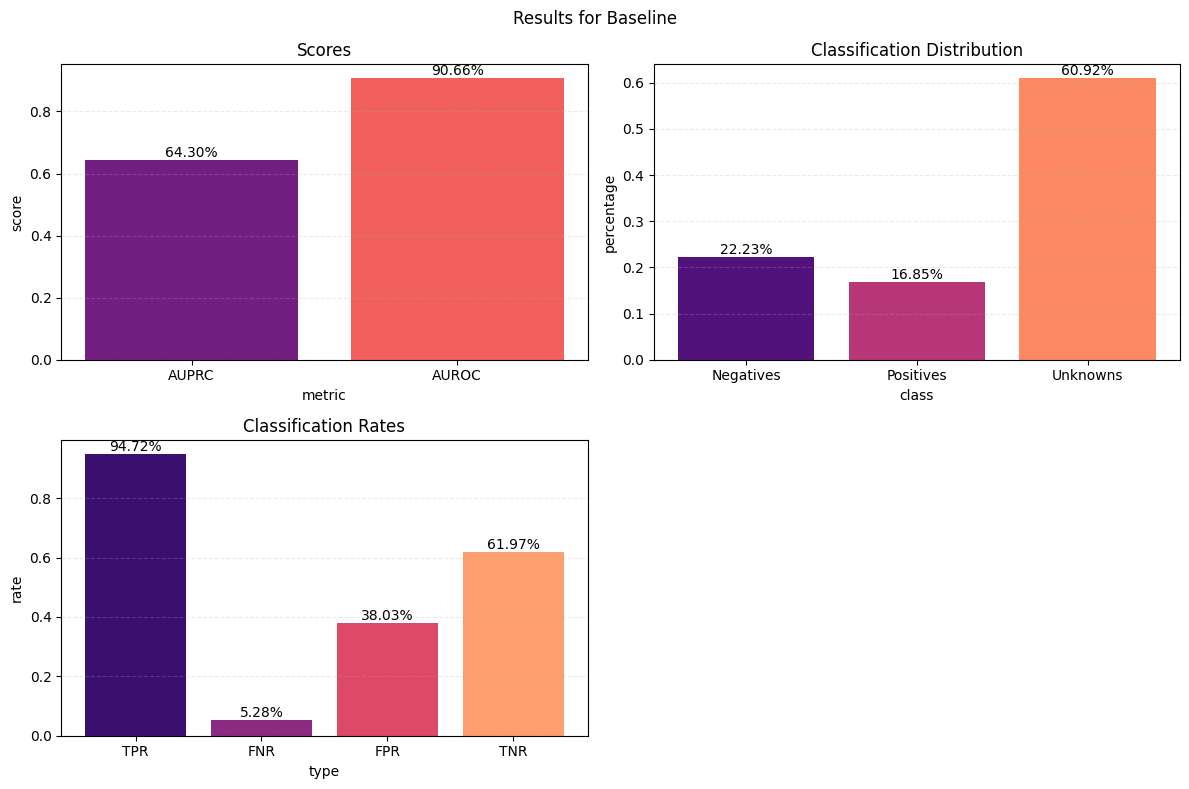

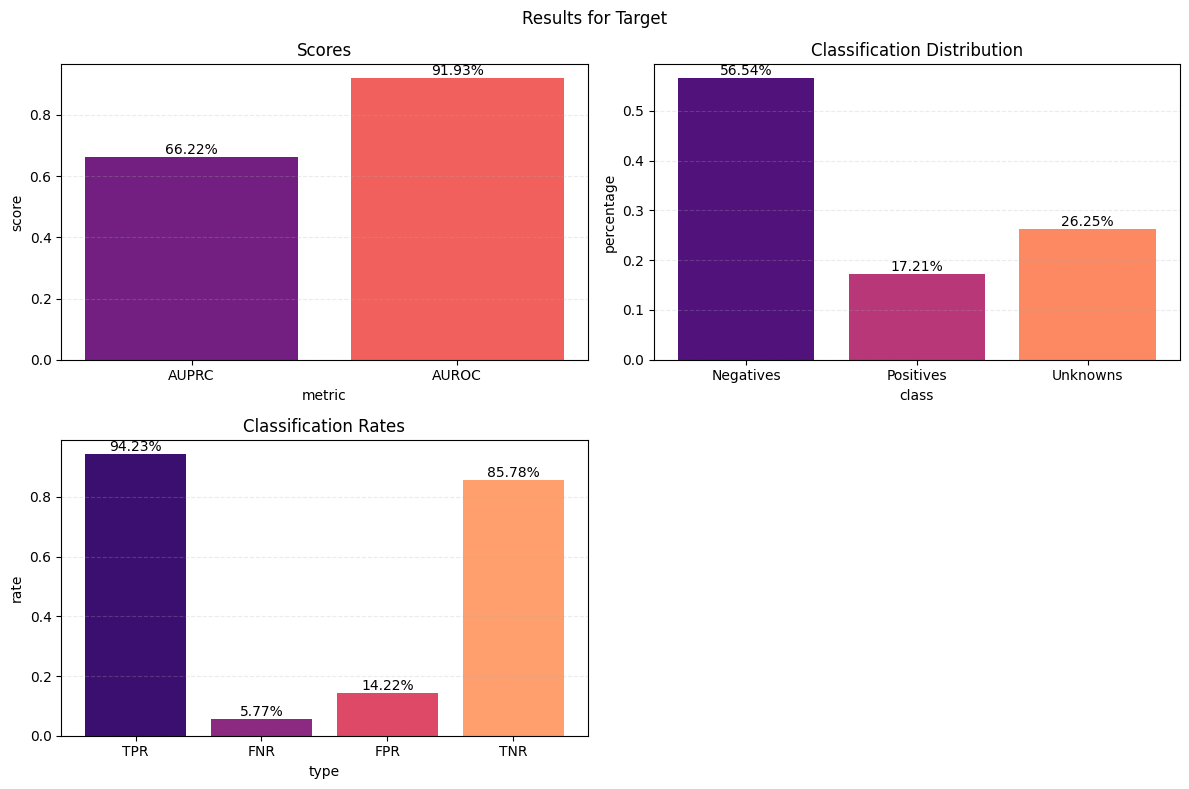

In [12]:
def show_result(result: dict, classifier: str) -> None:
    two_colors, three_colors, four_colors = [
        sns.color_palette("magma", number) for number in (2, 3, 4)
    ]
    fig, axs = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)
    ax1, ax2, ax3, ax4 = axs.flatten()

    ax1.bar(
        ["AUPRC", "AUROC"],
        [result["auprc"], result["auroc"]],
        color=two_colors,
    )
    ax1.grid(axis="y", linestyle="--", alpha=0.25)
    for i, value in enumerate([result["auprc"], result["auroc"]]):
        ax1.text(i, value, f"{value * 100:.2f}%", ha="center", va="bottom")
    ax1.set_xlabel("metric")
    ax1.set_ylabel("score")
    ax1.set_title("Scores")

    ax2.bar(
        ["Negatives", "Positives", "Unknowns"],
        [result["negatives"], result["positives"], result["unknowns"]],
        color=three_colors,
    )
    ax2.grid(axis="y", linestyle="--", alpha=0.25)
    for i, value in enumerate([result["negatives"], result["positives"], result["unknowns"]]):
        ax2.text(i, value, f"{value * 100:.2f}%", ha="center", va="bottom")
    ax2.set_xlabel("class")
    ax2.set_ylabel("percentage")
    ax2.set_title("Classification Distribution")

    ax3.bar(["TPR", "FNR", "FPR", "TNR"], result["rates"], color=four_colors)
    ax3.grid(axis="y", linestyle="--", alpha=0.25)
    for i, value in enumerate(result["rates"]):
        ax3.text(i, value, f"{value * 100:.2f}%", ha="center", va="bottom")
    ax3.set_xlabel("type")
    ax3.set_ylabel("rate")
    ax3.set_title("Classification Rates")

    # sns.heatmap(result["confusion_matrix"], annot=True, cmap="Blues", ax=ax4)
    # ax4.set_xticklabels(["Predicted 0", "Predicted 1"])
    # ax4.set_yticklabels(["Actual 0", "Actual 1"])
    # ax4.set_title("Confusion Matrix (mean)")
    ax4.axis("off")

    fig.suptitle(f"Results for {classifier.capitalize()}")
    fig.savefig(f"./resources/figures/ap_pro/{classifier}.png")
    plt.show()


for classifier, result in results.items():
    show_result(result, classifier)